Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np
import time

In [2]:
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Tuning params

In [3]:
steps = 20000
lr = 0.001
layers = np.array([1, 50, 50, 20, 50, 50, 1])

In [4]:
# function to approximate
def f(x):
    return torch.sin (x) 

In [5]:
class FCN (nn.Module):
    def __init__(self, layers):
        super().__init__()
        
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        
        self.linears = nn.ModuleList([nn.Linear (layers[i], layers[i+1]) for i in range(len(layers)-1)])
                
        # Xavier initialization
        for i in range (len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            
    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        
        a = x.float()
        
        # ugly way to make last layer linear
        for layer in self.linears[:-1]:
            z = layer(a)
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a

Generate data

In [6]:
x = torch.linspace(0, 2 * np.pi, 500).view(-1, 1)
y = f(x)

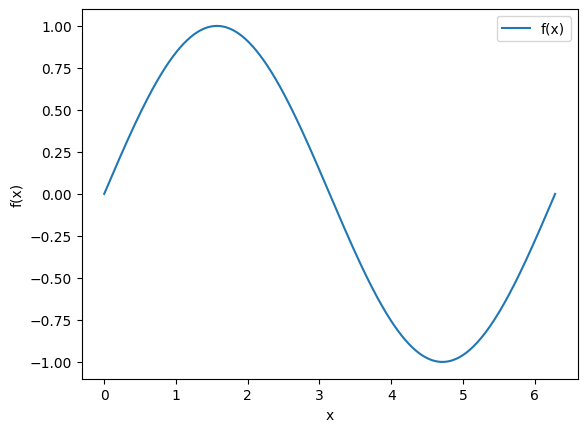

In [7]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(), y.detach().numpy(), label='f(x)')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.tick_params(axis='y')
ax1.legend()

In [8]:
indices = np.arange(500)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

x_train = x[train_idx].float().to(device)
y_train = y[train_idx].float().to(device)
x_test = x[test_idx].float().to(device)
y_test = y[test_idx].float().to(device)

Defining our NN

In [9]:
model = FCN(layers).to(device)
params = list(model.parameters())
optimizer = optim.Adam(params, lr=lr)

In [10]:
start_time = time.time()

for i in range (steps):
    optimizer.zero_grad()
    loss = model.loss_function(model(x_train), y_train)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print (f'Step {i}: Loss {loss.item()}')
        
end_time = time.time()
print (f'Training time: {end_time - start_time}s')

Step 0: Loss 0.821362316608429
Step 1000: Loss 0.0001467236434109509
Step 2000: Loss 2.5430026653339155e-05
Step 3000: Loss 1.0892075806623325e-05
Step 4000: Loss 9.4375309345196e-06
Step 5000: Loss 7.795288183842786e-06
Step 6000: Loss 4.90415504827979e-06
Step 7000: Loss 3.9229348658409435e-06
Step 8000: Loss 3.044310233235592e-06
Step 9000: Loss 3.138130978186382e-06
Step 10000: Loss 0.000714255787897855
Step 11000: Loss 7.933846973173786e-06
Step 12000: Loss 1.0085033864015713e-05
Step 13000: Loss 7.3353980951651465e-06
Step 14000: Loss 0.0005411893362179399
Step 15000: Loss 1.824849846343568e-06
Step 16000: Loss 9.810506753638037e-07
Step 17000: Loss 6.348761235130951e-05
Step 18000: Loss 1.0288403018421377e-06
Step 19000: Loss 2.6314585284126224e-06
Training time: 79.87604022026062s


In [11]:
yh = model(x_train)
yh_test = model(x_test)

_, idxs2 = torch.sort(x_train.squeeze(1))
_, idxs3 = torch.sort(x_test.squeeze(1))

x_train_plot = x_train[idxs2].cpu().detach().numpy()
y_train_plot = y_train[idxs2].cpu().detach().numpy()
yh_plot = yh[idxs2].cpu().detach().numpy()

x_test_plot = x_test[idxs3].cpu().detach().numpy()
y_test_plot = y_test[idxs3].cpu().detach().numpy()
yh_test_plot = yh_test[idxs3].cpu().detach().numpy()

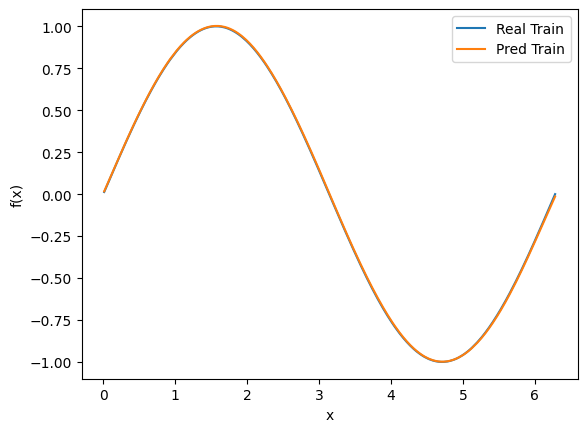

In [12]:
fig, ax1 = plt.subplots()
ax1.plot(x_train_plot, y_train_plot, label='Real Train')
ax1.plot(x_train_plot, yh_plot, label='Pred Train')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.tick_params(axis='y')
ax1.legend()

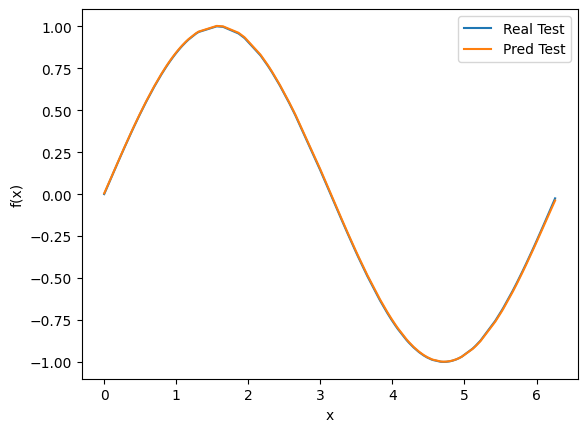

In [13]:
fig, ax1 = plt.subplots()
ax1.plot(x_test_plot, y_test_plot, label='Real Test')
ax1.plot(x_test_plot, yh_test_plot, label='Pred Test')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.tick_params(axis='y')
ax1.legend()